In [43]:
import os
import numpy as np
import cv2
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [44]:
# load images and assign labels
def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
    return images, [label] * len(images)

In [45]:
data_dir = 'Alzheimers'
folders = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
labels = {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}

all_images = []
all_labels = []
for folder in folders:
    images, label_list = load_images_from_folder(os.path.join(data_dir, folder), labels[folder])
    all_images.extend(images)
    all_labels.extend(label_list)

# Convert to numpy arrays
all_images = np.array(all_images).reshape(-1, 128, 128, 1) / 255.0
all_labels = to_categorical(all_labels, num_classes=4)

# Data Augmentation
data_augmentation = ImageDataGenerator(
    width_shift_range=0.05,  # small horizontal shifts
    height_shift_range=0.05, # small vertical shifts
    zoom_range=0.05,         # slight zoom
    horizontal_flip=True,    # horizontal flip
    fill_mode='nearest'
)

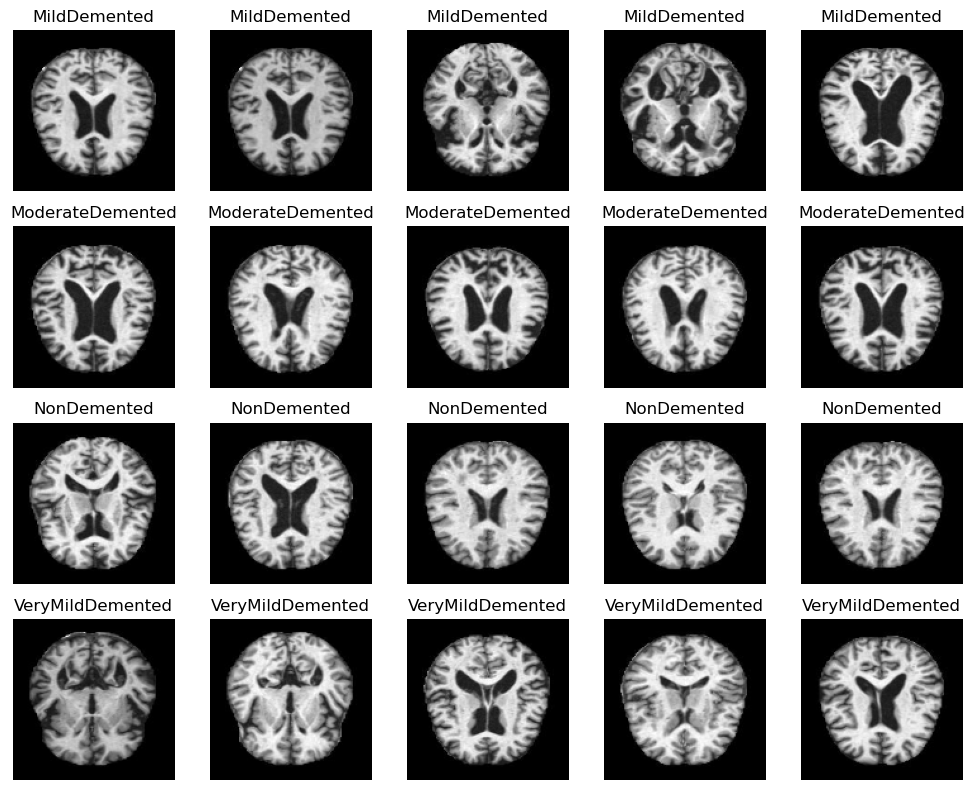

In [46]:
# display images
def display_images(images, labels, class_names, num_images=5):
    fig, axes = plt.subplots(nrows=len(class_names), ncols=num_images, figsize=(10, 2 * len(class_names)))
    for i, class_name in enumerate(class_names):
        class_images = [img for img, label in zip(images, labels) if np.argmax(label) == i]
        for j in range(num_images):
            if j < len(class_images):
                ax = axes[i, j]
                ax.imshow(class_images[j].squeeze(), cmap='gray')
                ax.set_title(class_name)
                ax.axis('off')
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
display_images(all_images, all_labels, class_names, num_images=5)


In [47]:
# 5-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
for train_index, val_index in kf.split(all_images, np.argmax(all_labels, axis=1)):
    X_train, X_val = all_images[train_index], all_images[val_index]
    y_train, y_val = all_labels[train_index], all_labels[val_index]

    # Data augmentation for training data
    train_generator = data_augmentation.flow(X_train, y_train, batch_size=32)

##### Decision Trees

In [48]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

Accuracy Score: 0.72


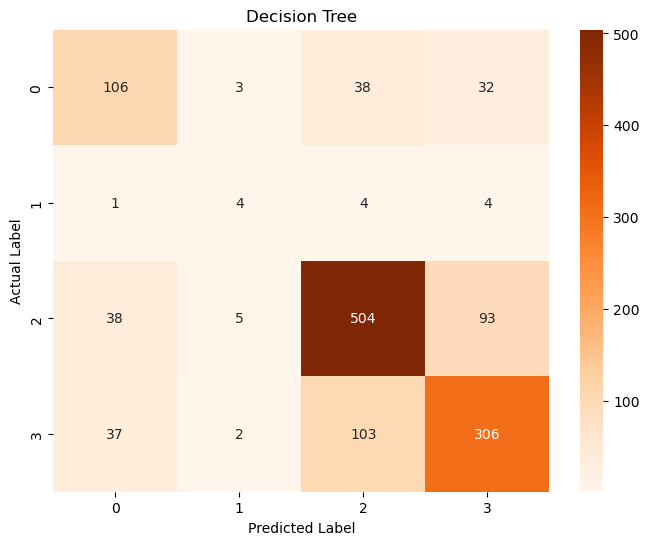

In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

def fit_classifier(clf, X_train, y_train):
    clf.fit(X_train, y_train)
    return clf

def evaluate_classifier(clf, X_val, y_val):
    y_pred = clf.predict(X_val)
    y_val_multiclass = np.argmax(y_val, axis=1)
    y_pred_multiclass = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_val, y_pred)
    print(f'Accuracy Score: {accuracy:.2f}')

    cm = confusion_matrix(y_val_multiclass, y_pred_multiclass)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.title('Decision Tree')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

dt_classifier = DecisionTreeClassifier(random_state=14)
fitted_dt_clf = fit_classifier(dt_classifier, X_train, y_train)
evaluate_classifier(fitted_dt_clf, X_val, y_val)

##### Bagging

/Users/catedombrowski/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy Score: 0.91


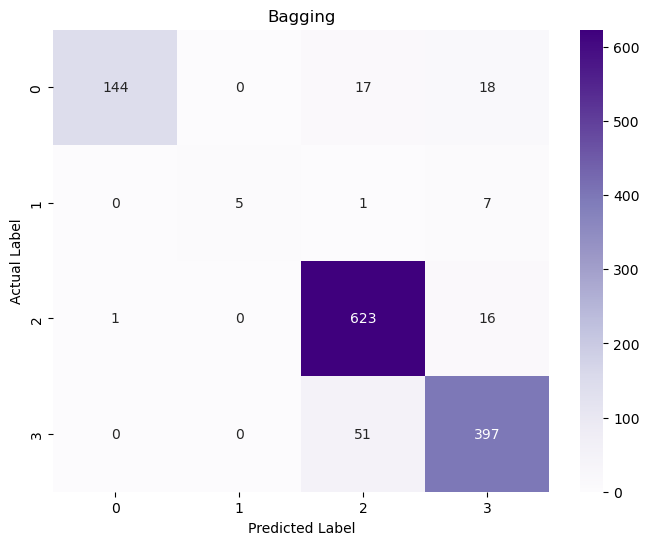

In [54]:

from sklearn.ensemble import BaggingClassifier

def fit_classifier(clf, X_train, y_train):
    y_train_multiclass = np.argmax(y_train, axis=1)
    clf.fit(X_train, y_train_multiclass)
    return clf

def evaluate_classifier(clf, X_val, y_val):
    y_pred = clf.predict(X_val)
    y_val_multiclass = np.argmax(y_val, axis=1)
    accuracy = accuracy_score(y_val_multiclass, y_pred)
    print(f'Accuracy Score: {accuracy:.2f}')

    cm = confusion_matrix(y_val_multiclass, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
    plt.title('Bagging')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

bag_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=25, random_state=42)
fitted_bag_clf = fit_classifier(bag_clf, X_train, y_train)
evaluate_classifier(fitted_bag_clf, X_val, y_val)

##### Random Forest

Accuracy: 0.94


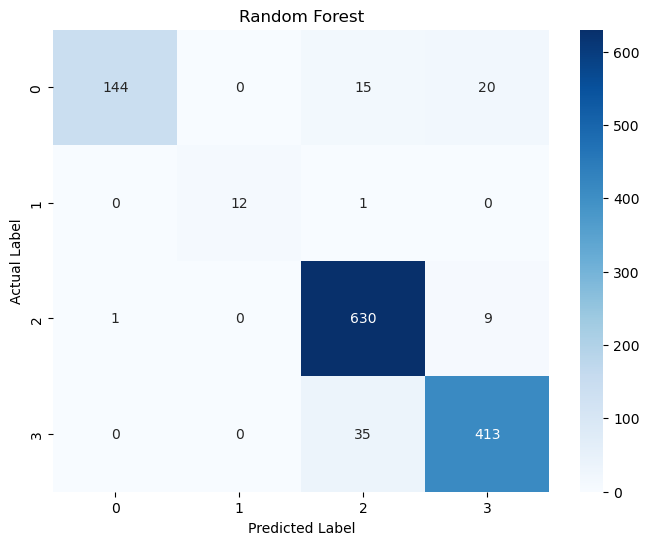

RandomForestClassifier(criterion='entropy', random_state=42)

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


def grid_search_for_classifier(clf, param_grid, X_train, y_train):
    grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train)
    clf.set_params(**grid_search.best_params_)
    return clf

def train_and_evaluate_classifier(clf, X_train, y_train, X_val, y_val):
    if y_train.ndim > 1:
        y_train = np.argmax(y_train, axis=1)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    # Convert y_val to multiclass format if necessary
    if y_val.ndim > 1:
        y_val = np.argmax(y_val, axis=1)
    
    acc_score = accuracy_score(y_val, y_pred)
    print(f"Accuracy: {acc_score:.2f}")

    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    return clf

param_grid = {
    "n_estimators": [10, 50, 100],
    "max_features": ['sqrt', 'log2'],
    "criterion": ['gini', 'entropy'],
    "random_state": [42]
}

rf_clf = RandomForestClassifier()
rf_clf = grid_search_for_classifier(rf_clf, param_grid, X_train, y_train)
train_and_evaluate_classifier(rf_clf, X_train, y_train, X_val, y_val)